# SPINN (single)

In [ ]:
from setproctitle import setproctitle
setproctitle("SPINN")

In [ ]:
import os

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

In [ ]:
from cmspinn.spinn_jax import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [ ]:
from pathlib import Path

In [ ]:
# b_bottom_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_000000.npy')
# Nz = 160
# b_norm = 2500

# b_bottom_date = os.path.basename(b_bottom_path)[9:-4]
# output_path = os.path.join(Path(b_bottom_path).parent.parent, f'SPINN/{b_bottom_date}')

In [ ]:
b_bottom_path = os.path.expanduser('~/workspace/_data/lowlou_64_64_64/b_bottom.npy')
Nz = 64
b_norm = 100

output_path = os.path.join(Path(b_bottom_path).parent, 'SPINN')

In [ ]:
os.makedirs(output_path, exist_ok=True)

In [ ]:
with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

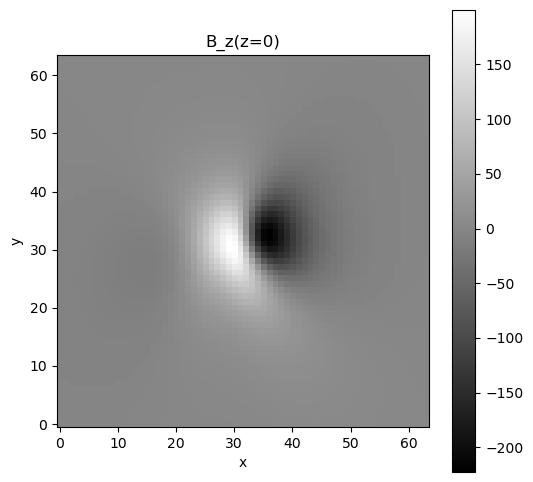

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [ ]:
Nx, Ny, _ = b_bottom.shape


In [ ]:
boundary_path = os.path.join(output_path, 'boundary.pickle')

In [ ]:
with open(boundary_path, 'rb') as f:
    boundary_data = pickle.load(f)

In [ ]:
epochs = 10000
log_iter = 1000

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

In [ ]:
pos_enc = 0
mlp = 'modified_mlp'

In [ ]:
parameters = {'feat_sizes' : feat_sizes, 
              'r' : r, 
              'out_dim' : out_dim, 
              'Nx' : Nx, 
              'Ny' : Ny, 
              'Nz' : Nz, 
              'b_norm' : b_norm,
              'pos_enc' : pos_enc,
              'mlp' : mlp}

In [ ]:
parameters_path = os.path.join(output_path, "parameters.pickle")
with open(parameters_path, "wb") as f:
    pickle.dump(parameters, f)

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(subkey, Nx, Ny, Nz)
train_boundary_data = [train_data, boundary_data]

In [ ]:
losses = []

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [ ]:
params_path = os.path.join(output_path, "params_0.pickle")
with open(params_path, "wb") as f:
    pickle.dump(params, f)

In [ ]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     generate_train_data(subkey, Nx, Ny, Nz, nc=160)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 10%|█         | 1005/10000 [00:10<02:03, 72.76it/s]

Epoch: 1000/10000 --> total loss: 0.00228871


 20%|██        | 2015/10000 [00:22<01:22, 97.12it/s] 

Epoch: 2000/10000 --> total loss: 0.00138152


 30%|███       | 3014/10000 [00:33<01:17, 90.28it/s] 

Epoch: 3000/10000 --> total loss: 0.00099446


 40%|████      | 4016/10000 [00:44<01:03, 94.78it/s] 

Epoch: 4000/10000 --> total loss: 0.00096232


 50%|█████     | 5006/10000 [00:55<00:55, 90.21it/s]

Epoch: 5000/10000 --> total loss: 0.00088359


 60%|██████    | 6008/10000 [01:06<00:47, 84.30it/s]

Epoch: 6000/10000 --> total loss: 0.00139348


 70%|███████   | 7011/10000 [01:17<00:31, 94.87it/s] 

Epoch: 7000/10000 --> total loss: 0.00116981


 80%|████████  | 8015/10000 [01:28<00:21, 92.16it/s] 

Epoch: 8000/10000 --> total loss: 0.00069397


 90%|█████████ | 9015/10000 [01:39<00:11, 85.95it/s] 

Epoch: 9000/10000 --> total loss: 0.00093243


100%|██████████| 10000/10000 [01:50<00:00, 90.29it/s]

Epoch: 10000/10000 --> total loss: 0.00143891
Runtime --> total: 110.76sec (11.08ms/iter.)


In [ ]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
    losses = np.load(f)

Text(0, 0.5, 'Loss')

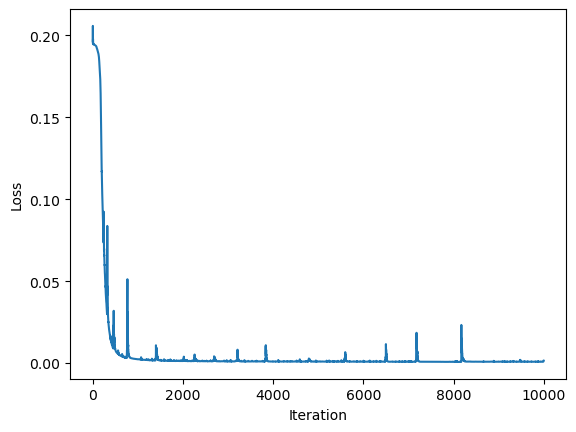

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')